# Adjust CSV

In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv(r"C:\Users\krish\ai-power-converter\machine-learning\simulation_results_8000.csv")

# Specify the columns you want to remove
columns_to_remove = ["No"]  # Specify the columns you want to remove

# Drop the specified columns
df_truncated = df.drop(columns=columns_to_remove)

# Save the truncated DataFrame back to a CSV file
df_truncated.to_csv("modified_8000_dataset.csv", index=False)


# Machine Learning



Epoch 1/50

591/591 [==============================] - 2s 1ms/step - loss: 19.5468 - val_loss: 13.6714
Epoch 2/50
591/591 [==============================] - 1s 1ms/step - loss: 15.6623 - val_loss: 12.5869
Epoch 3/50
591/591 [==============================] - 1s 1ms/step - loss: 15.1929 - val_loss: 12.2164
Epoch 4/50
591/591 [==============================] - 1s 1ms/step - loss: 14.9354 - val_loss: 12.0596
Epoch 5/50
591/591 [==============================] - 1s 1ms/step - loss: 14.7671 - val_loss: 12.4616
Epoch 6/50
591/591 [==============================] - 1s 1ms/step - loss: 14.6802 - val_loss: 11.9480
Epoch 7/50
591/591 [==============================] - 1s 1ms/step - loss: 14.6166 - val_loss: 11.6225
Epoch 8/50
591/591 [==============================] - 1s 1ms/step - loss: 14.4820 - val_loss: 11.6372
Epoch 9/50
591/591 [==============================] - 1s 1ms/step - loss: 14.4239 - val_loss: 11.1214
Epoch 10/50
591/591 [==============================] - 1s 1ms/step - loss: 14.2

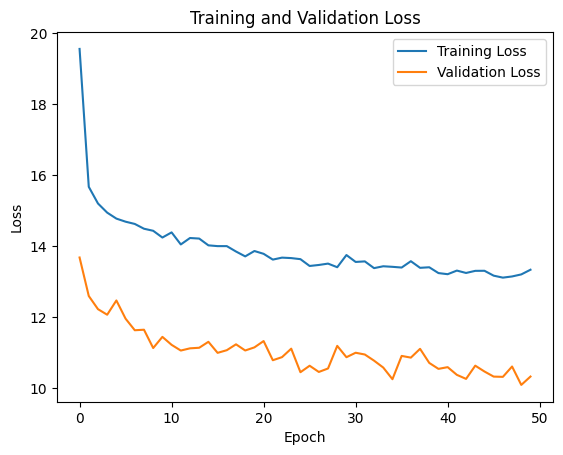

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter\simulation_results_30.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Scale input features to range [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(3,)),  # Scalarization layer
    tf.keras.layers.Dense(128, activation='relu'),          # Hidden layer 1
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(128, activation='relu'),          # Hidden layer 2
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(128, activation='relu'),          # Hidden layer 2
    tf.keras.layers.BatchNormalization(),         
    tf.keras.layers.Dense(6, activation='softplus')                               # Output layer with 6 neurons
])


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with custom callback to print information at the end of each epoch
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[PrintEpochInfo()], verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing Set

In [4]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Use the trained model to make predictions on the testing set
predictions = model.predict(X_test)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R-squared (R2) Score
r2 = r2_score(y_test, predictions)
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

127/127 [==============================] - 0s 506us/step - loss: 27.6778
Mean Squared Error on Testing Set: 27.677839279174805
127/127 [==============================] - 0s 487us/step
Predictions:
[[1.3914518e-02 7.0942074e-02 3.0633345e+00 3.0563385e+00 1.0154480e-02
  1.2447828e+00]
 [1.6459341e+00 2.1871805e+01 3.0402115e-01 3.0381173e-01 6.0150460e-03
  1.8971719e-01]
 [5.2582896e-01 1.0637988e+01 3.3238196e+00 3.3557818e+00 3.7819608e-03
  2.0286436e+00]
 [1.9662058e-01 2.8731686e+01 6.4888015e+00 6.4709077e+00 4.8952538e-04
  4.1546712e+00]
 [3.8638505e-01 2.4814219e+01 5.4214578e+00 5.4281301e+00 3.8164689e-03
  3.5034866e+00]]
True Values:
[[8.24785561e-02 1.66608588e+00 3.20658853e+00 3.20658853e+00
  1.78710824e-02 9.70550404e-01]
 [2.91178140e+00 2.29786406e+01 2.41527236e-01 2.41527236e-01
  3.22857138e-04 7.06838663e-02]
 [5.65812618e-01 9.54536162e+00 3.61795960e+00 3.61795960e+00
  3.17092808e-03 2.32065136e+00]
 [2.90574366e-01 3.40931078e+01 8.29842095e+00 8.29842095e+

### New Dataset

## Save Model

In [ ]:
# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Optionally, save the model
model.save("ripples_prediction_model.h5")


# Learning rate

Epoch 1/50
175/175 [==============================] - 1s 2ms/step - loss: 1.2234 - val_loss: 1.7656 - lr: 0.0010
Epoch 2/50
175/175 [==============================] - 0s 1ms/step - loss: 0.6549 - val_loss: 1.0154 - lr: 0.0010
Epoch 3/50
175/175 [==============================] - 0s 1ms/step - loss: 0.5471 - val_loss: 0.4504 - lr: 0.0010
Epoch 4/50
175/175 [==============================] - 0s 1ms/step - loss: 0.4482 - val_loss: 0.3793 - lr: 0.0010
Epoch 5/50
175/175 [==============================] - 0s 993us/step - loss: 0.4080 - val_loss: 0.2820 - lr: 0.0010
Epoch 6/50
175/175 [==============================] - 0s 995us/step - loss: 0.3904 - val_loss: 0.3865 - lr: 0.0010
Epoch 7/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3694 - val_loss: 0.2995 - lr: 0.0010
Epoch 8/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3481 - val_loss: 0.2085 - lr: 0.0010
Epoch 9/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3345 - val_loss:

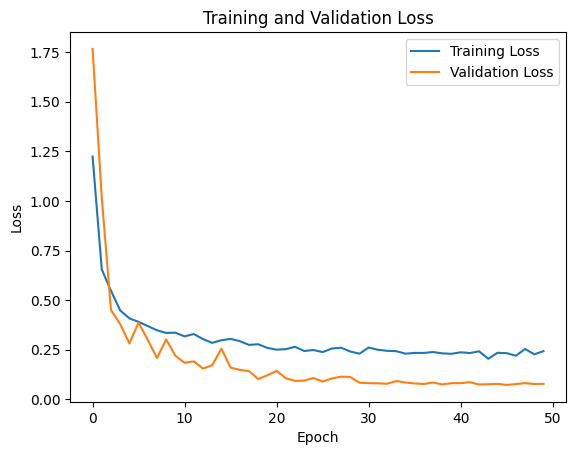

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\modified_8000_dataset.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Scale input features to range [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(3,)),  # Scalarization layer
    tf.keras.layers.Dense(128, activation='relu'),          # Hidden layer 1
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(128, activation='relu'),          # Hidden layer 2
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(128, activation='relu'),          # Hidden layer 2
    tf.keras.layers.BatchNormalization(),         
    tf.keras.layers.Dense(6, activation='softplus')                               # Output layer with 6 neurons
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)

# Train the model with custom callback to print information at the end of each epoch
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[PrintEpochInfo(), lr_scheduler], verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [4]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Use the trained model to make predictions on the testing set
predictions = model.predict(X_test)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R-squared (R2) Score
r2 = r2_score(y_test, predictions)
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

38/38 [==============================] - 0s 539us/step - loss: 0.0629
Mean Squared Error on Testing Set: 0.06294810026884079
38/38 [==============================] - 0s 557us/step
Predictions:
[[0.23502189 6.2860556  2.7613482  2.7268744  0.01654533 1.2104152 ]
 [0.19514255 3.8450208  3.566086   3.5879862  0.00777144 0.9791483 ]
 [0.22899619 6.3094788  3.505091   3.5292187  0.00873752 1.2150187 ]
 [0.07136555 4.3774595  2.344827   2.4066882  0.01689915 2.3335888 ]
 [0.03926335 0.36918607 2.0810337  2.0723252  0.15860869 1.8347393 ]]
True Values:
[[0.26001435 4.23264405 2.74299141 2.74299141 0.01217656 1.29224261]
 [0.19503469 3.32206237 3.59940991 3.59940991 0.00902757 0.95760415]
 [0.23933468 4.23420079 3.51435724 3.51435724 0.00733677 1.291914  ]
 [0.08042573 4.24613856 2.40471154 2.40471154 0.02217949 2.34150863]
 [0.07897327 0.58997409 2.02413572 2.02413572 0.16765618 2.15456352]]
Mean Absolute Error (MAE): 0.10503029345821109
Root Mean Squared Error (RMSE): 0.2508945834110917
R-sq

# Regularization

Epoch 1/50
175/175 [==============================] - 1s 2ms/step - loss: 1.4066 - val_loss: 1.9925
Epoch 2/50
175/175 [==============================] - 0s 1ms/step - loss: 0.8953 - val_loss: 1.2823
Epoch 3/50
175/175 [==============================] - 0s 1ms/step - loss: 0.7376 - val_loss: 0.6063
Epoch 4/50
175/175 [==============================] - 0s 1ms/step - loss: 0.6458 - val_loss: 0.5722
Epoch 5/50
175/175 [==============================] - 0s 1ms/step - loss: 0.6061 - val_loss: 0.4935
Epoch 6/50
175/175 [==============================] - 0s 1ms/step - loss: 0.5835 - val_loss: 0.5227
Epoch 7/50
175/175 [==============================] - 0s 1ms/step - loss: 0.5506 - val_loss: 0.4360
Epoch 8/50
175/175 [==============================] - 0s 1ms/step - loss: 0.5172 - val_loss: 0.3710
Epoch 9/50
175/175 [==============================] - 0s 1ms/step - loss: 0.4944 - val_loss: 0.4576
Epoch 10/50
175/175 [==============================] - 0s 1ms/step - loss: 0.4934 - val_loss: 0.3459

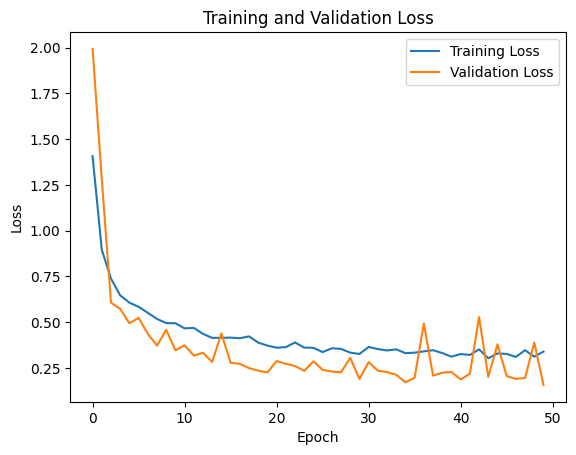

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\modified_8000_dataset.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Scale input features to range [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(3,)),  # Scalarization layer
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 1 with L2 regularization
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 2 with L2 regularization
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 3 with L2 regularization
    tf.keras.layers.BatchNormalization(),         
    tf.keras.layers.Dense(6, activation='softplus')         # Output layer with 6 neurons
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with custom callback to print information at the end of each epoch
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[PrintEpochInfo()], verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [6]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Use the trained model to make predictions on the testing set
predictions = model.predict(X_test)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R-squared (R2) Score
r2 = r2_score(y_test, predictions)
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

38/38 [==============================] - 0s 566us/step - loss: 0.1331
Mean Squared Error on Testing Set: 0.13309261202812195
38/38 [==============================] - 0s 596us/step
Predictions:
[[0.20082536 6.230992   2.7514365  2.7137249  0.01573089 1.388107  ]
 [0.12976019 4.0259047  3.5531693  3.5769985  0.0091845  1.1573942 ]
 [0.12025575 6.2353673  3.5358517  3.526031   0.00674823 1.3967868 ]
 [0.12134684 4.447689   2.415328   2.4096045  0.02262336 2.2768736 ]
 [0.0797136  0.0990125  2.065913   2.1743486  0.13387764 1.8214028 ]]
True Values:
[[0.26001435 4.23264405 2.74299141 2.74299141 0.01217656 1.29224261]
 [0.19503469 3.32206237 3.59940991 3.59940991 0.00902757 0.95760415]
 [0.23933468 4.23420079 3.51435724 3.51435724 0.00733677 1.291914  ]
 [0.08042573 4.24613856 2.40471154 2.40471154 0.02217949 2.34150863]
 [0.07897327 0.58997409 2.02413572 2.02413572 0.16765618 2.15456352]]
Mean Absolute Error (MAE): 0.13227839656718074
Root Mean Squared Error (RMSE): 0.3001898765397438
R-sq

# Learning rate + regularization

Epoch 1/100
175/175 [==============================] - 2s 3ms/step - loss: 3.1939 - val_loss: 3.0995 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 0s 2ms/step - loss: 2.4275 - val_loss: 2.3823 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 0s 2ms/step - loss: 2.1360 - val_loss: 1.6864 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 0s 2ms/step - loss: 1.9602 - val_loss: 1.5189 - lr: 0.0010
Epoch 5/100
175/175 [==============================] - 0s 2ms/step - loss: 1.8334 - val_loss: 1.5150 - lr: 0.0010
Epoch 6/100
175/175 [==============================] - 0s 2ms/step - loss: 1.7399 - val_loss: 1.4097 - lr: 0.0010
Epoch 7/100
175/175 [==============================] - 0s 2ms/step - loss: 1.6719 - val_loss: 1.2489 - lr: 0.0010
Epoch 8/100
175/175 [==============================] - 0s 2ms/step - loss: 1.5996 - val_loss: 1.3709 - lr: 0.0010
Epoch 9/100
175/175 [==============================] - 0s 2ms/step - loss: 1.5627 - val_

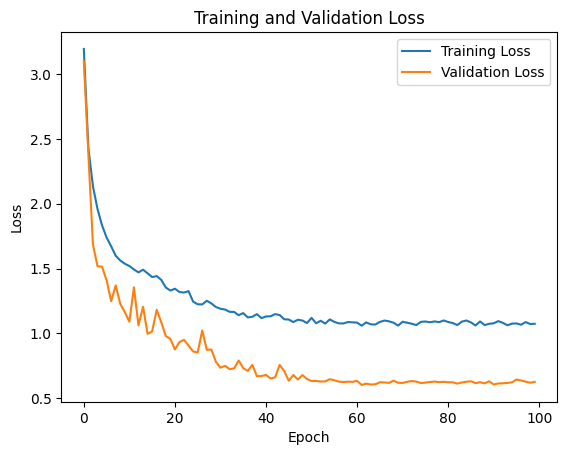

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import pickle

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter\simulation_results_8000.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Scale input features to range [0, 1]
scaler_X = MinMaxScaler()
scaler_X.fit(X)
X_scaled = scaler_X.transform(X)

# Save the scaler for input features
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(3,)),  # Scalarization layer
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 1 with L2 regularization
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 2 with L2 regularization
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 3 with L2 regularization
    tf.keras.layers.BatchNormalization(),         
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 2 with L2 regularization
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 3 with L2 regularization
    tf.keras.layers.BatchNormalization(),       
    tf.keras.layers.Dense(6, activation='softplus')         # Output layer with 6 neurons
])


# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')



# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)

# Train the model with custom callback to print information at the end of each epoch
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[PrintEpochInfo(), lr_scheduler], verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [7]:
# Optionally, save the model
model.save("model_5_256_new_data_8000.h5")

d:\Krishna\Python_3_92\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Use the trained model to make predictions on the testing set
predictions = model.predict(X_test)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R-squared (R2) Score
r2 = r2_score(y_test, predictions)
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

38/38 [==============================] - 0s 728us/step - loss: 0.7453
Mean Squared Error on Testing Set: 0.7453218102455139
38/38 [==============================] - 0s 842us/step
Predictions:
[[1.1075776e+00 2.1912855e+01 9.0382582e-01 9.2892766e-01 1.3802417e-03
  2.6815724e-01]
 [3.6810243e-01 3.5392979e+01 7.9123330e+00 7.9220567e+00 6.9064377e-03
  4.9242830e+00]
 [1.1033121e+00 2.1966997e+01 1.1739205e+00 1.1832414e+00 1.1782497e-03
  3.0296481e-01]
 [2.4792113e+00 2.3817371e+01 2.2270787e-01 2.2464100e-01 7.9196354e-04
  6.6556208e-02]
 [2.9330111e+00 1.1955777e+01 1.5234838e+00 1.5806195e+00 7.5073857e-03
  1.3320720e+00]]
True Values:
[[8.85486951e-01 2.29004040e+01 8.97694327e-01 8.97694327e-01
  3.84320137e-04 2.56721714e-01]
 [3.49940858e-01 3.73969575e+01 8.16266040e+00 8.16266040e+00
  9.26426461e-03 4.95932575e+00]
 [8.66057054e-01 2.29162033e+01 1.15073070e+00 1.15073070e+00
  2.31794553e-04 2.56455414e-01]
 [2.85996060e+00 2.35175604e+01 2.17285929e-01 2.17285929e-01
  

In [6]:
print(X_test)

[[0.84239734 0.59292035 0.52631111]
 [0.16648169 0.7699115  0.94736667]
 [0.84239734 0.59292035 0.94736667]
 ...
 [0.2336293  0.38827434 0.42105   ]
 [0.62930078 0.68141593 0.26315556]
 [0.54439512 0.04756637 0.52631111]]


# Load Model

In [10]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pickle
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model(r'D:\Krishna\ai-power-converter\machine-learning\model_5_256_new_data_8000.h5')

with open(r'D:\Krishna\ai-power-converter\machine-learning\scaler_X.pkl', 'rb') as f:
    scaler_X = pickle.load(f)

# Define the input values
input_values = np.array([0.001116,0.000986,20000])  # Replace these values with your actual input values

# # Initialize the MinMaxScaler with the same parameters used for training data
# scaler = MinMaxScaler()  # You can also load the scaler if you saved it during training

# Reshape the input data to ensure it is in the correct shape for normalization
input_values_reshaped = input_values.reshape(1, -1)  # Reshape to (1, 3)

# Fit the scaler to the training data and transform the new input data
input_values_scaled = scaler_X.transform(input_values_reshaped)

# Make predictions using the model
prediction = model.predict(input_values_scaled)
# 3e-05,3e-05,29473.684210526317,4.173315066606831,19.44152069744096,1.9789759711750268,1.9789759711750268,0.5375860903195137,1.1010299411829958
# 0.0006521052631578,0.0001194736842105,143157.89473684208,0.0867577616798147,1.8022857528367369,3.1017004916475472,3.1017004916475472,0.0155677936159264,1.3457323804555696

# Define the original output values obtained from your simulation
original_output = np.array([19.947900060524393,19.627897339250875,0.05242590131845117,0.05242590131845117,2.6498508548111126e-05,0.06666227153008698])  # Replace these values with your actual output values

# Calculate the mean absolute error between original and predicted output values
mae = np.mean(np.abs(original_output - prediction))

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((original_output - prediction) / original_output)) * 100

# Print the original and predicted output values for comparison
print("Original output:", original_output)
print("Predicted output:", prediction)
print("Mean Absolute Error:", mae)
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')


1/1 [==============================] - 0s 84ms/step
Original output: [1.99479001e+01 1.96278973e+01 5.24259013e-02 5.24259013e-02
 2.64985085e-05 6.66622715e-02]
Predicted output: [[6.0937414e+00 1.8913715e+01 5.2517891e-02 5.1863380e-02 5.2732159e-04
  1.0214596e-01]]
Mean Absolute Error: 2.4341632742368855
Mean Absolute Percentage Error (MAPE): 336.2621039508372%


model_5_256.h5
Original output: [0.08675776 1.80228575 3.10170049 3.10170049 0.01556779 1.34573238]
Predicted output: [[0.07611273 2.215468   3.096919   3.093316   0.01535417 1.3317415 ]]
Mean Absolute Error: 0.07519960021255918
Mean Absolute Percentage Error (MAPE): 6.338601044481275%

model_3_256.h5
Original output: [0.08675776 1.80228575 3.10170049 3.10170049 0.01556779 1.34573238]
Predicted output: [[0.11215301 2.2457957  3.0929043  3.0988061  0.01894178 1.3158761 ]]
Mean Absolute Error: 0.08563766249885481
Mean Absolute Percentage Error (MAPE): 13.02466772681769%

# RMS Prop

Epoch 1/50
175/175 [==============================] - 1s 2ms/step - loss: 1.3723 - val_loss: 2.0780 - lr: 0.0010
Epoch 2/50
175/175 [==============================] - 0s 1ms/step - loss: 0.8917 - val_loss: 1.1374 - lr: 0.0010
Epoch 3/50
175/175 [==============================] - 0s 1ms/step - loss: 0.7452 - val_loss: 0.5997 - lr: 0.0010
Epoch 4/50
175/175 [==============================] - 0s 995us/step - loss: 0.6561 - val_loss: 0.5572 - lr: 0.0010
Epoch 5/50
175/175 [==============================] - 0s 1ms/step - loss: 0.5902 - val_loss: 0.4939 - lr: 0.0010
Epoch 6/50
175/175 [==============================] - 0s 1ms/step - loss: 0.5465 - val_loss: 0.3991 - lr: 0.0010
Epoch 7/50
175/175 [==============================] - 0s 1ms/step - loss: 0.5119 - val_loss: 0.3499 - lr: 0.0010
Epoch 8/50
175/175 [==============================] - 0s 1ms/step - loss: 0.4891 - val_loss: 0.3384 - lr: 0.0010
Epoch 9/50
175/175 [==============================] - 0s 991us/step - loss: 0.4711 - val_loss:

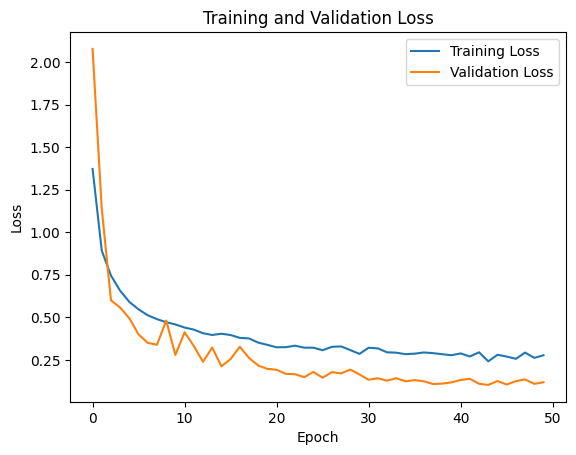

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\modified_8000_dataset.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Scale input features to range [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(3,)),  # Scalarization layer
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 1 with L2 regularization
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 2 with L2 regularization
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 3 with L2 regularization
    tf.keras.layers.BatchNormalization(),         
    tf.keras.layers.Dense(6, activation='softplus')         # Output layer with 6 neurons
])


# Compile the model
model.compile(optimizer='rmsprop', loss='mean_squared_error')

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)

# Train the model with custom callback to print information at the end of each epoch
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[PrintEpochInfo(), lr_scheduler], verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Use the trained model to make predictions on the testing set
predictions = model.predict(X_test)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R-squared (R2) Score
r2 = r2_score(y_test, predictions)
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

38/38 [==============================] - 0s 553us/step - loss: 0.1015
Mean Squared Error on Testing Set: 0.10151327401399612
38/38 [==============================] - 0s 590us/step
Predictions:
[[0.2402902  6.232463   2.746162   2.7138426  0.01332015 1.3009593 ]
 [0.17782037 3.8699996  3.6420228  3.6356173  0.01064756 0.99274427]
 [0.20618252 6.2622733  3.5509279  3.541892   0.00684249 1.2777478 ]
 [0.09381189 4.2164288  2.3735504  2.4219313  0.02222215 2.3234973 ]
 [0.05052076 0.23102275 2.0582287  2.0428379  0.16217932 1.775365  ]]
True Values:
[[0.26001435 4.23264405 2.74299141 2.74299141 0.01217656 1.29224261]
 [0.19503469 3.32206237 3.59940991 3.59940991 0.00902757 0.95760415]
 [0.23933468 4.23420079 3.51435724 3.51435724 0.00733677 1.291914  ]
 [0.08042573 4.24613856 2.40471154 2.40471154 0.02217949 2.34150863]
 [0.07897327 0.58997409 2.02413572 2.02413572 0.16765618 2.15456352]]
Mean Absolute Error (MAE): 0.10480539460036697
Root Mean Squared Error (RMSE): 0.2516952678478091
R-sq

# Leaky RELU

Epoch 1/50
175/175 [==============================] - 1s 2ms/step - loss: 1.2462 - val_loss: 1.7970 - lr: 0.0010
Epoch 2/50
175/175 [==============================] - 0s 1ms/step - loss: 0.7317 - val_loss: 0.9107 - lr: 0.0010
Epoch 3/50
175/175 [==============================] - 0s 1ms/step - loss: 0.6091 - val_loss: 0.6091 - lr: 0.0010
Epoch 4/50
175/175 [==============================] - 0s 1ms/step - loss: 0.4883 - val_loss: 0.5152 - lr: 0.0010
Epoch 5/50
175/175 [==============================] - 0s 1ms/step - loss: 0.4656 - val_loss: 0.4533 - lr: 0.0010
Epoch 6/50
175/175 [==============================] - 0s 992us/step - loss: 0.4473 - val_loss: 0.3768 - lr: 0.0010
Epoch 7/50
175/175 [==============================] - 0s 1ms/step - loss: 0.4219 - val_loss: 0.3779 - lr: 0.0010
Epoch 8/50
175/175 [==============================] - 0s 993us/step - loss: 0.3958 - val_loss: 0.3357 - lr: 0.0010
Epoch 9/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3809 - val_loss:

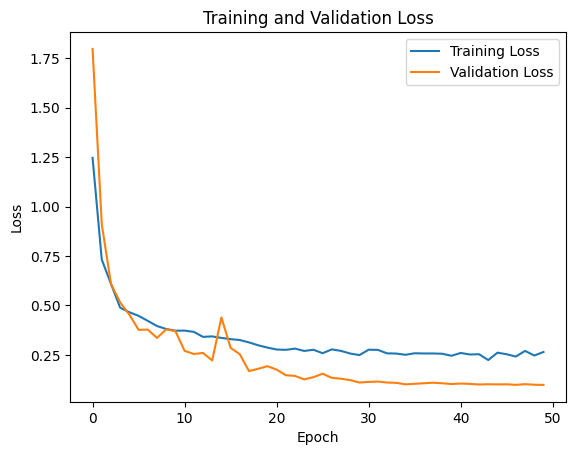

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\modified_8000_dataset.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Scale input features to range [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(3,)),  # Scalarization layer
    tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU()),          # Hidden layer 1 with Leaky ReLU activation
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU()),          # Hidden layer 2 with Leaky ReLU activation
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU()),          # Hidden layer 3 with Leaky ReLU activation
    tf.keras.layers.BatchNormalization(),         
    tf.keras.layers.Dense(6, activation='softplus')        # Output layer with 6 neurons
])


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)

# Train the model with custom callback to print information at the end of each epoch
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[PrintEpochInfo(), lr_scheduler], verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Use the trained model to make predictions on the testing set
predictions = model.predict(X_test)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R-squared (R2) Score
r2 = r2_score(y_test, predictions)
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

38/38 [==============================] - 0s 512us/step - loss: 0.0812
Mean Squared Error on Testing Set: 0.08118176460266113
38/38 [==============================] - 0s 574us/step
Predictions:
[[2.2372349e-01 6.5856242e+00 2.7237141e+00 2.7210276e+00 1.3876152e-02
  1.1909441e+00]
 [8.5043728e-02 3.9640625e+00 3.6377962e+00 3.6348629e+00 4.6907477e-03
  1.0148597e+00]
 [1.3811299e-01 6.5202332e+00 3.4814725e+00 3.4228482e+00 7.6108500e-03
  1.2223406e+00]
 [8.3701901e-02 4.3729987e+00 2.3616626e+00 2.4198308e+00 2.5489850e-02
  2.3562801e+00]
 [6.9189437e-02 4.7254691e-01 2.1140597e+00 2.0983272e+00 1.6960685e-01
  1.8209836e+00]]
True Values:
[[0.26001435 4.23264405 2.74299141 2.74299141 0.01217656 1.29224261]
 [0.19503469 3.32206237 3.59940991 3.59940991 0.00902757 0.95760415]
 [0.23933468 4.23420079 3.51435724 3.51435724 0.00733677 1.291914  ]
 [0.08042573 4.24613856 2.40471154 2.40471154 0.02217949 2.34150863]
 [0.07897327 0.58997409 2.02413572 2.02413572 0.16765618 2.15456352]]
Me

# Normalize output too

C:\Users\Krishna\AppData\Local\Temp\ipykernel_39148\2737613888.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd





Epoch 1/50

150/150 [==============================] - 1s 2ms/step - loss: 0.3959 - val_loss: 0.2977 - lr: 0.0010
Epoch 2/50
150/150 [==============================] - 0s 1ms/step - loss: 0.2220 - val_loss: 0.2007 - lr: 0.0010
Epoch 3/50
150/150 [==============================] - 0s 1ms/step - loss: 0.1605 - val_loss: 0.1412 - lr: 0.0010
Epoch 4/50
150/150 [==============================] - 0s 1ms/step - loss: 0.1172 - val_loss: 0.0995 - lr: 0.0010
Epoch 5/50
150/150 [==============================] - 0s 1ms/step - loss: 0.0848 - val_loss: 0.0713 - lr: 0.0010
Epoch 6/50
150/150 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0519 - lr: 0.0010
Epoch 7/50
150/150 [==============================] - 0s 1ms/step - loss: 0.0446 - val_loss: 0.0374 - lr: 0.0010
Epoch 8/50
150/150 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0271 - lr: 0.0010
Epoch 9/50
150/150 [==============================] - 0s 1ms/step - loss: 0.0247 - val_loss:

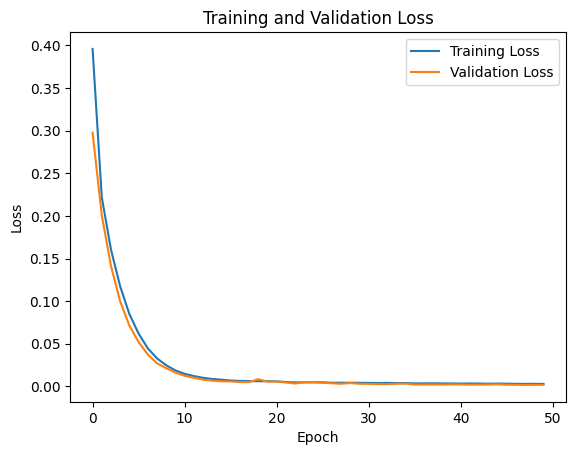

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import pickle

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\modified_8000_dataset.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset




# Split the dataset into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 60% training, 20% validation

# Initialize the scalers for input features and output labels
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scalers to the training data only
scaler_X.fit(X_train)
scaler_y.fit(y_train)

# Save the scaler for output features
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)
    pickle.dump(scaler_X, f)

# Normalize input features and output labels for each split
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)
# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(3,)),  # Scalarization layer
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 1 with L2 regularization
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 2 with L2 regularization
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden layer 3 with L2 regularization
    tf.keras.layers.BatchNormalization(),         
    tf.keras.layers.Dense(6, activation='softplus')         # Output layer with 6 neurons
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)

# Train the model with custom callback to print information at the end of each epoch
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), callbacks=[PrintEpochInfo(), lr_scheduler], verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [4]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Evaluate the model on the testing set
mse = model.evaluate(X_test_scaled, y_test_scaled)
print("Mean Squared Error on Testing Set:", mse)

# Use the trained model to make predictions on the testing set
predictions = model.predict(X_test_scaled)

import pickle

with open('scaler_y.pkl', 'rb') as f:
    scaler_y = pickle.load(f)
    
# Inverse normalize the predictions
predictions_inverse = scaler_y.inverse_transform(predictions)

# Print the inverse normalized predictions
print("Inverse Normalized Predictions:")
print(predictions_inverse[:5])

# # Print the first few predictions
# print("Predictions:")
# print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions_inverse)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions_inverse))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R-squared (R2) Score
r2 = r2_score(y_test, predictions_inverse)
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - predictions_inverse) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

50/50 [==============================] - 0s 539us/step - loss: 0.0016
Mean Squared Error on Testing Set: 0.0015870683128014207
50/50 [==============================] - 0s 478us/step
Inverse Normalized Predictions:
[[0.16533414 2.1927168  3.2556512  3.3036149  0.02482356 1.2475835 ]
 [0.25063488 1.8994693  2.07807    2.0703905  0.05199311 1.2747641 ]
 [0.28082585 1.183465   2.0842202  2.0932484  0.10294329 1.1492    ]
 [0.22268148 2.7095819  2.4725616  2.4867458  0.03383224 1.3159201 ]
 [0.17999716 5.161921   2.0357695  2.0684764  0.02849861 1.8483555 ]]
True Values:
[[0.08457126 2.18663945 3.2465735  3.2465735  0.01331712 1.30348585]
 [0.19104057 1.49711012 2.00347397 2.00347397 0.06100972 1.32946182]
 [0.22120715 0.77914996 2.06333663 2.06333663 0.12593984 0.99901587]
 [0.10575051 3.4653138  2.527336   2.527336   0.0243426  1.36408376]
 [0.20829303 3.91019612 2.01655789 2.01655789 0.02741329 2.14507822]]
Mean Absolute Error (MAE): 0.14635558290285228
Root Mean Squared Error (RMSE): 0.

In [24]:
# Optionally, save the model
model.save("model_scaled.h5")

d:\Krishna\Python_3_92\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the model
model = tf.keras.models.load_model(r'D:\Krishna\ai-power-converter\machine-learning\model_scaled.h5')

# Define the input values
input_values = np.array([3e-5, 3e-5, 20000])  # Replace these values with your actual input values

# Initialize the MinMaxScaler with the same parameters used for training data
scaler = MinMaxScaler()  # You can also load the scaler if you saved it during training

# Reshape the input data to ensure it is in the correct shape for normalization
input_values_reshaped = input_values.reshape(1, -1)  # Reshape to (1, 3)

# Fit the scaler to the training data and transform the new input data
input_values_scaled = scaler.fit_transform(input_values_reshaped)

# Make predictions using the model
prediction = model.predict(input_values_scaled)


# Define the original output values obtained from your simulation
original_output = np.array([4.590348642657058,22.68086689404757,2.5727074420928684,2.5727074420928684,1.5819122871435367,2.3244217067619])  # Replace these values with your actual output values

# Calculate the mean absolute error between original and predicted output values
mae = np.mean(np.abs(original_output - prediction))

# Print the original and predicted output values for comparison
print("Original output:", original_output)
print("Predicted output:", prediction)
print("Mean Absolute Error:", mae)
